In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../datasets/Phishing_Email.csv')
df.head(3)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email


In [2]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [3]:
df.dropna(inplace=True)

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [5]:
df.rename(columns={"Email Text": "feature", "Email Type": "target"}, inplace=True)
df.head()

,feature,target
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [6]:
df.shape

(18634, 2)

In [7]:
"""
Now we do Data Preprocessing.
"""
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

regexp = RegexpTokenizer("[\w']+")

def convert_to_lowercase(text):
    return text.lower()
def remove_whitespace(text):
    return text.strip()
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)
# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

In [8]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_stopwords(text)
    text = discard_non_alpha(text)
    return text

In [9]:
df['feature'] = df['feature'].apply(text_normalizer)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), max_features=15000, smooth_idf=True, sublinear_tf=True)
vectorizer.fit(df['feature'])
df_features = vectorizer.transform(df['feature'])
df_target = df['target']

df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features.toarray(), df_target, test_size = 0.2, random_state=42)

In [11]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(df_features_train, df_target_train)
target_prediction = nb_model.predict(df_features_test)

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [13]:
print(f"classification report: \n{classification_report(df_target_test, target_prediction)}")

classification report: 
                precision    recall  f1-score   support

Phishing Email       0.95      0.96      0.95      1518
    Safe Email       0.97      0.96      0.97      2209

      accuracy                           0.96      3727
     macro avg       0.96      0.96      0.96      3727
  weighted avg       0.96      0.96      0.96      3727



In [14]:
accuracy_score(df_target_test, target_prediction)

0.9605580896163134

In [15]:
import seaborn as sns
import numpy as np

cf_matrix = confusion_matrix(df_target_test, target_prediction)
#sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True)
cf_matrix

array([[1450,   68],
       [  79, 2130]])

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_true_binary = label_encoder.fit_transform(df_target_test)

y_score = nb_model.predict_proba(df_features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
roc_auc = auc(fpr, tpr)

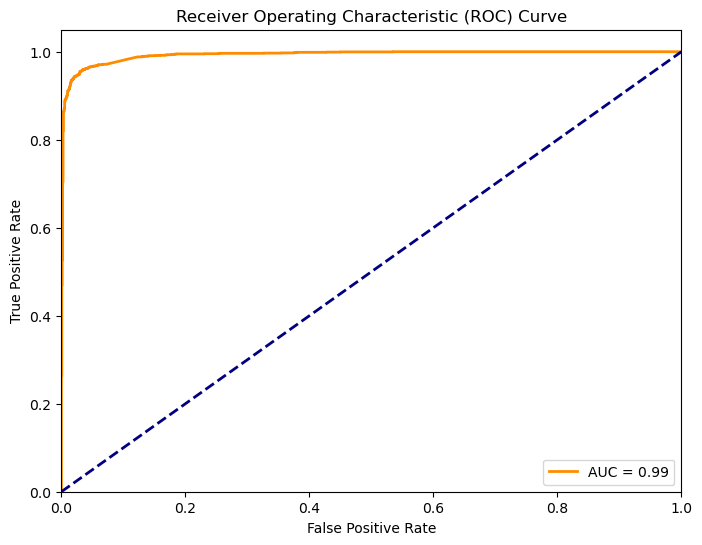

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()